In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import MultipleLocator

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})

import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

%config InlineBackend.figure_format = 'retina'

In [2]:
tpm = pd.read_csv('/data5/16p12_RNA/GTEx/data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct', 
                  skiprows=2, sep='\t')

tpm.Name = tpm.Name.apply(lambda s: s.split('.')[0])

tpm = tpm.set_index('Name')

tpm = tpm.drop('Description', axis=1)

In [3]:
med = pd.read_csv('/data5/16p12_RNA/GTEx/data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz', sep='\t', skiprows=2)
med.gene_id = med.gene_id.apply(lambda s: s.split('.')[0])
med = med.set_index('gene_id')

med = med.drop('Description', axis=1)

In [4]:
pheno = pd.read_csv('/data5/16p12_RNA/GTEx/data/GTEx_v7_Annotations_SubjectPhenotypesDS.txt', sep='\t')
att = pd.read_csv('/data5/16p12_RNA/GTEx/data/GTEx_v7_Annotations_SampleAttributesDS.txt', sep='\t')
att = att.set_index('SAMPID', drop=False)

In [5]:
keep = pd.read_csv('../outlier_expression_analysis/keep.tsv', sep='\t')
keep = keep.ensembl.to_list()
de = pd.read_csv('../differential_expression_analysis/output/edgr_exclude_one/intersect.tsv', sep='\t')
de = de.ensembl.to_list()

In [6]:
brain_tissues = [s for s in att.SMTSD.unique() if s.startswith('Brain')]
lcl_tissue    = 'Cells - EBV-transformed lymphocytes'

lcl_samples = att[(att.SMTSD == lcl_tissue) & (att.SMAFRZE != 'EXCLUDE')].SAMPID.to_list()

brain_samples = {}
for t in brain_tissues:
    brain_samples[t] = att[(att.SMTSD == t) & (att.SMAFRZE != 'EXCLUDE')].SAMPID.to_list()

In [7]:
tissues = [lcl_tissue] + brain_tissues

- Brain - Cortex
- Brain - Cerebellum
- Brain - Hippocampus
- Brain - Substantia nigra
- Brain - Anterior cingulate cortex (BA24)
- Brain - Frontal Cortex (BA9)
- Brain - Cerebellar Hemisphere
- Brain - Caudate (basal ganglia)
- Brain - Nucleus accumbens (basal ganglia)
- Brain - Putamen (basal ganglia)
- Brain - Hypothalamus
- Brain - Spinal cord (cervical c-1)
- Brain - Amygdala



In [8]:
med_keep = med.loc[keep].copy()

In [9]:
cordf = pd.DataFrame(index=tissues, columns=tissues)

for t1 in tissues:
    for t2 in tissues:
        cor = spearmanr(med_keep[t1], med_keep[t2])
        cordf.at[t1,t2] = cor[0]


In [10]:
for col in cordf:
    cordf[col] = cordf[col].astype(float)

In [11]:
g = sns.clustermap(data=cordf, cmap='Blues', linewidths=0.01)

plt.close()
cordf = cordf[pd.Series(cordf.columns)[g.dendrogram_col.reordered_ind]]
cordf = cordf.loc[pd.Series(cordf.index)[g.dendrogram_row.reordered_ind]]

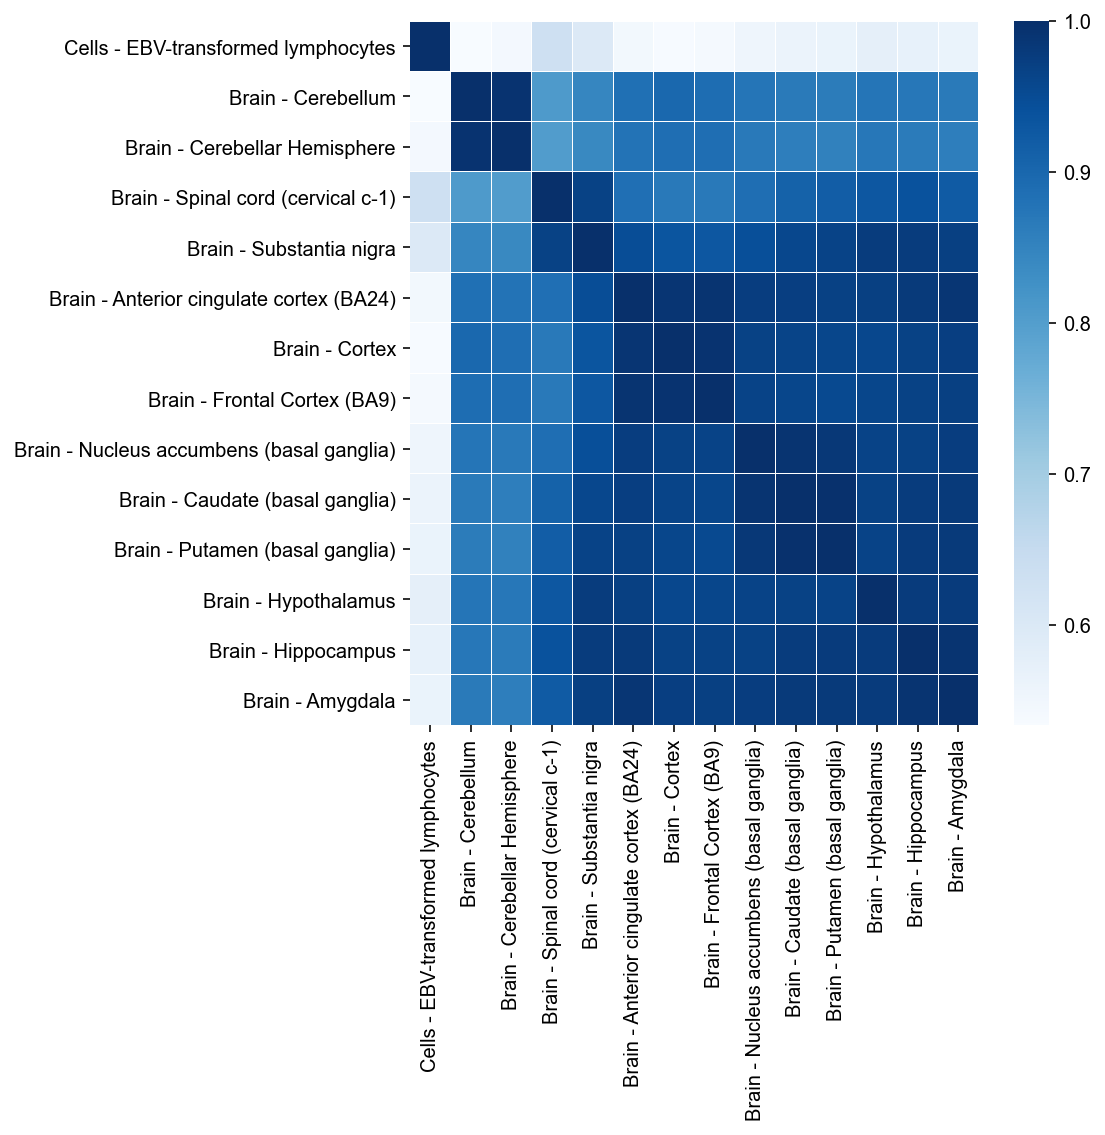

In [12]:
plt.figure(figsize=(8,8))

g = sns.heatmap(data=cordf, cmap='Blues', linewidths=0.01)

plt.tight_layout()
plt.savefig('figures/S19_gtex_heat.pdf', dpi=300)